In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import time, sleep
from fpga_ctrl import FpgaControl

%load_ext autoreload
%autoreload 2

# Utilities

In [2]:
# Global constants
SAMPLES_PER_LINE = 16384
GAINS_MAX = 32
LINES_MAX = 32
SAMPLE_W = 10
SAMPLE_N = 2 ** SAMPLE_W
SAMPLE_FREQ = 63.75

In [3]:
# Utility functions
def line_to_voltage(line):
    return [((2 * 3.3) / SAMPLE_N) * ((w & (SAMPLE_N - 1)) - SAMPLE_N // 2) for w in line]

def gain_to_voltage(gain):
    return [(1.0 / SAMPLE_N) * g for g in gain]

def gain_expand(gain, length=SAMPLES_PER_LINE):
    return [gain[x // (length // GAINS_MAX)] for x in range(length)]

def gain_staircase(step_width=1, max_value=1024):
    step_val = max_value // GAINS_MAX
    return [step_val - 1 + step_val * step_width * (i // step_width) for i in range(GAINS_MAX)]

def line_complex_sin(offset = 0):
    return [int(512 + 200 * np.sin(2 * np.pi * offset * 1E6 / 127.5E6 + 2 * np.pi * i * 1E6 / 63.75E6) + 
                      100 * np.sin(2 * np.pi * offset * 2E6 / 127.5E6 + 2 * np.pi * i * 2E6 / 63.75E6 ) -
                      80 * np.sin(2 * np.pi * offset * 5E6 / 127.5E6 + 2 * np.pi * i * 5E6 / 63.75E6 ) +
                      20 * np.sin(2 * np.pi * offset * 8E6 / 127.5E6 + 2 * np.pi * i * 8E6 / 63.75E6 )) for i in range(SAMPLES_PER_LINE)]

def plot_line(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = line_to_voltage(line)
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), len(line))
    # prepare time
    t = [1.0 / SAMPLE_FREQ * x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.show()

def plot_line_raw(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = [w & (SAMPLE_N - 1) for w in line]
    # prepare gain
    _gain = gain_expand(gain, len(line))
    # prepare time
    t = [x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Sample n')
    ax1.set_ylabel('ADC code', color='b')
    ax2.set_ylabel('DAC code', color='g')
    plt.tight_layout()
    plt.show()

def plot_interleaved_lines(title, line0, line1, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    il_len = len(line0) * 2
    il_freq = SAMPLE_FREQ * 2
    # prepare line 0
    _line0 = line_to_voltage(line0)
    t0 = [1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare line 1
    _line1 = line_to_voltage(line1)
    t1 = [1.0 / il_freq + 1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare interleaved line
    il_line = [_line1[i//2] if i % 2 else _line0[i//2] for i in range(il_len)]
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), il_len)
    # prepare time
    t = [1.0 / il_freq * x for x in range(il_len)]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, il_line, 'b-')
    if dots:
        ax1.plot(t0, _line0, 'ro')
        ax1.plot(t1, _line1, 'yo')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.show()

In [4]:
# For debug purposes - run only for utility functions debugging
#test_line0 = line_complex_sin(0)
#test_line1 = line_complex_sin(1)
#test_gain = gain_staircase(4)
#
#plot_line("Test plot line 0", test_line0, test_gain)
#plot_line("Test plot line 0 with zoom", test_line0, test_gain, [1.0, 5.0])
#plot_line("Test plot line 1 with zoom", test_line1, test_gain, [1.0, 2.0])
#
#plot_line_raw("Test plot line 0 raw data", test_line0, test_gain)
#plot_line_raw("Test plot line 0 raw data and zoom", test_line0, test_gain, [1000, 1200])
#
#plot_interleaved_lines("Test plot interleaved line", test_line0, test_line1, test_gain)
#plot_interleaved_lines("Test plot interleaved line with zoom", test_line0, test_line1, test_gain, [2.0, 4.0], True)

# Acquisition demonstration

## Connect FPGA

In [5]:
# init FTDI device
fpga = FpgaControl('ftdi://ftdi:2232:/', spi_freq=8E6)
# reload configuration (optional step - just to fill BRAM (DACGAIN registers) with initial values)
fpga.reload()
# reset fpga
fpga.reset()

## Do acquisition

### Simple acquisition with no gain

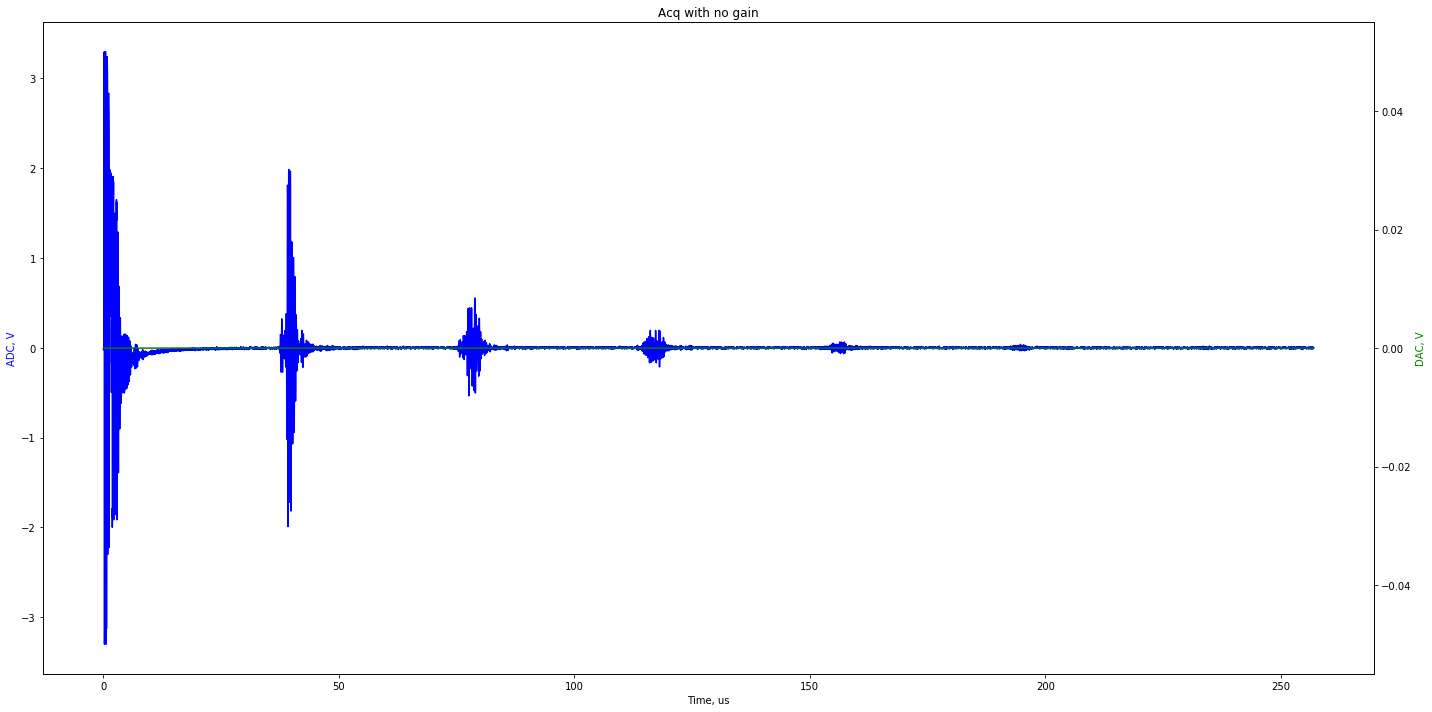

In [6]:
gain = [0]*32
acq_res = fpga.do_acquisition(acq_lines=1, gain=gain, double_rate=False)
plot_line("Acq with no gain", acq_res[0], gain)

### Acuisition of several lines with some gain

False


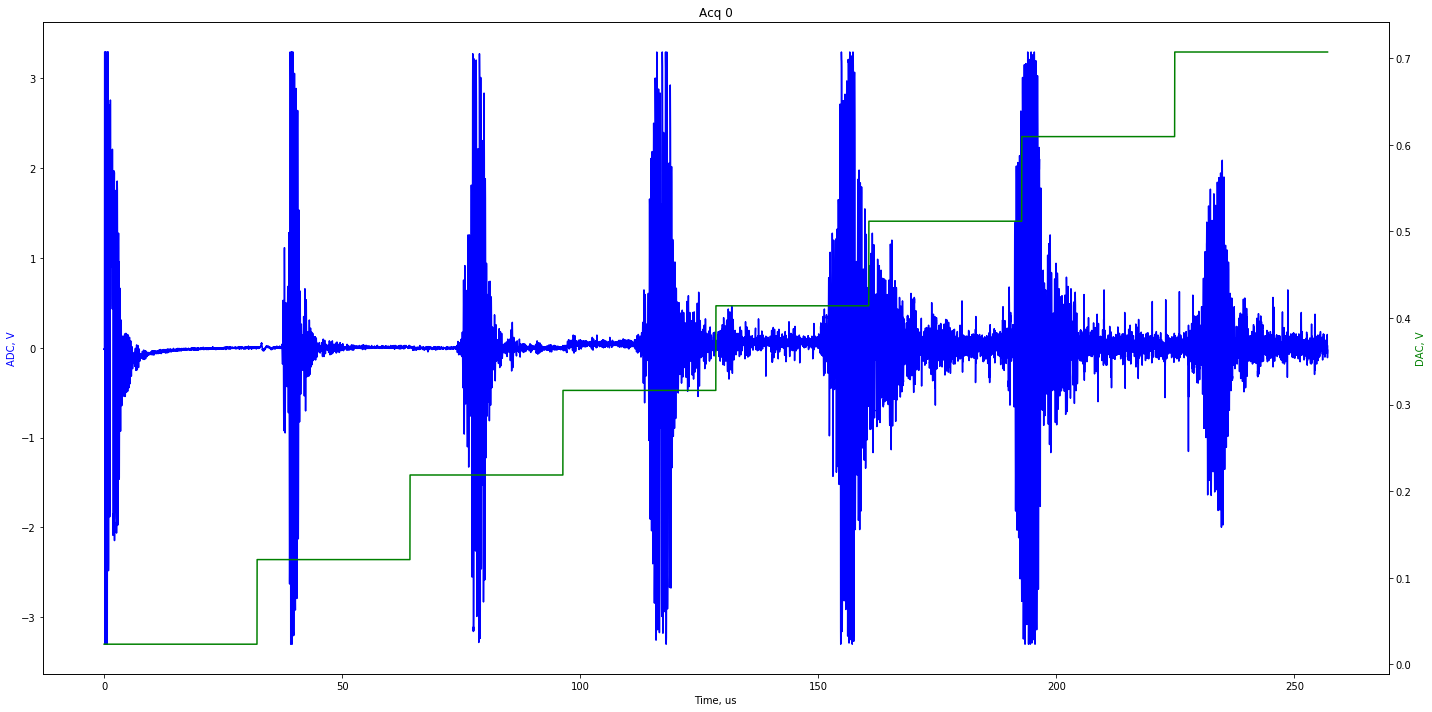

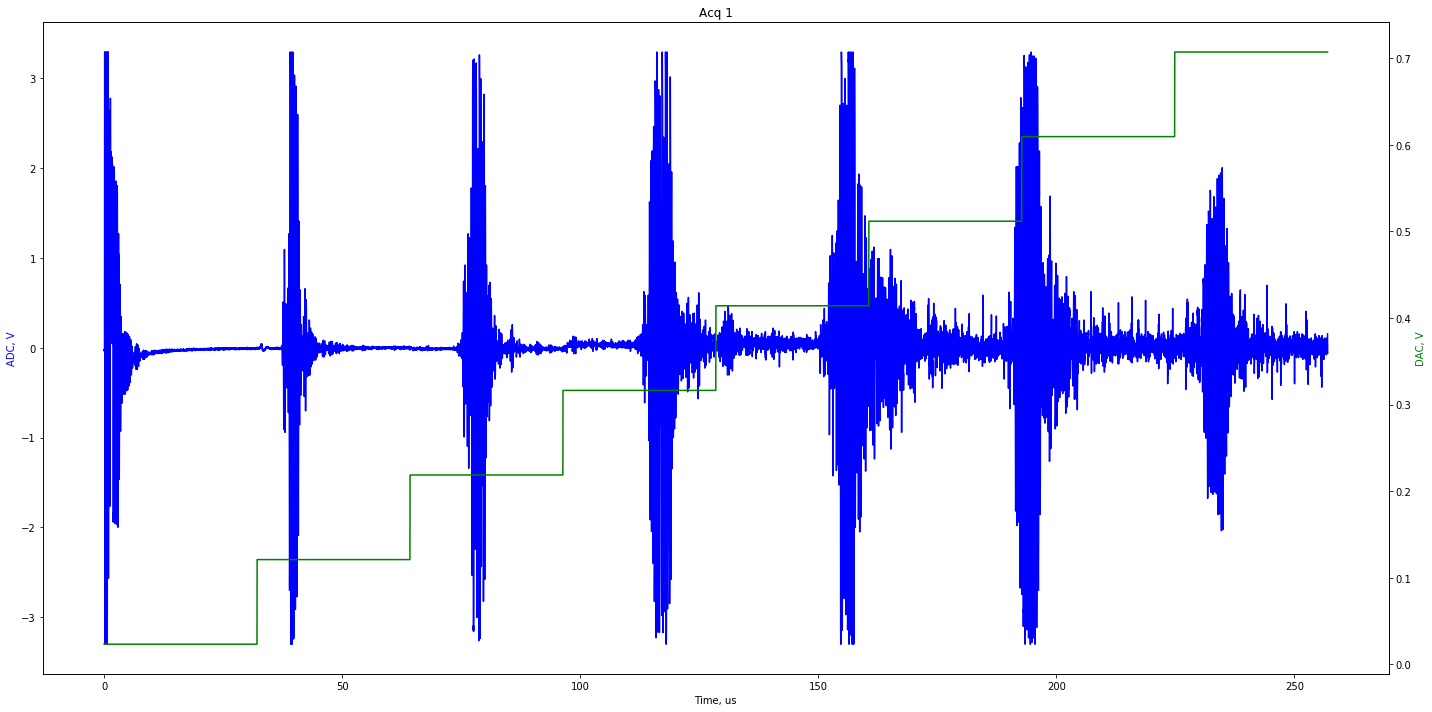

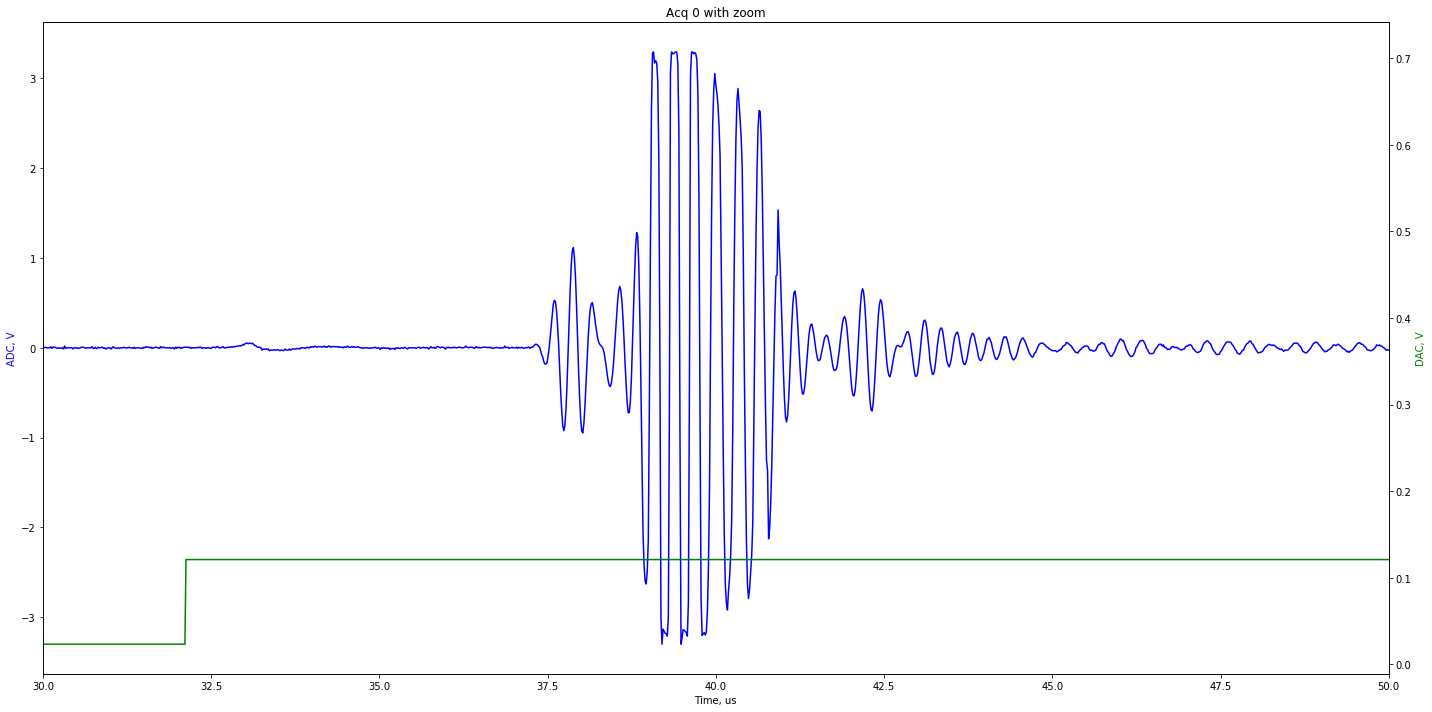

In [7]:
gain = gain_staircase(4, 800)
acq_res = fpga.do_acquisition(acq_lines=2, gain=gain, double_rate=False)

print(acq_res[0] == acq_res[1])
plot_line("Acq 0", acq_res[0], gain)
plot_line("Acq 1", acq_res[1], gain)
plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])

### Interleaved acuisition

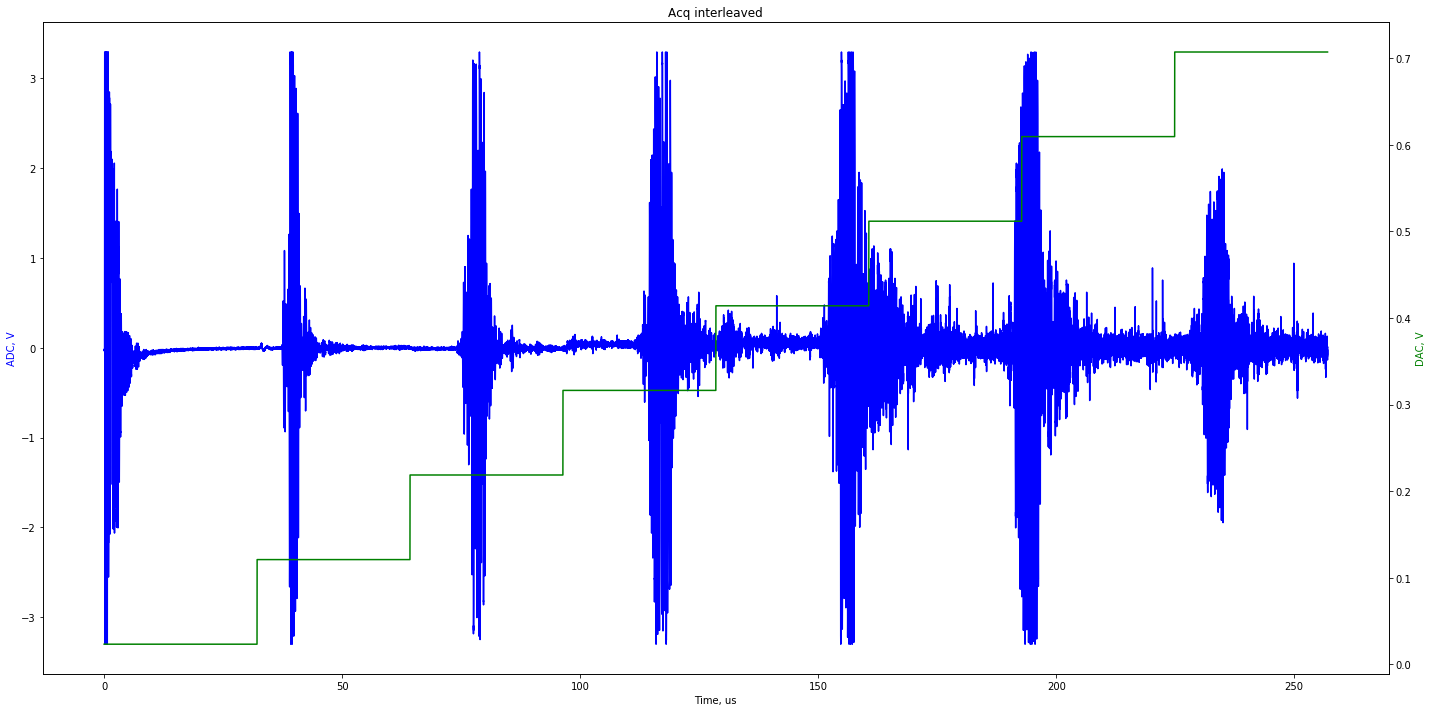

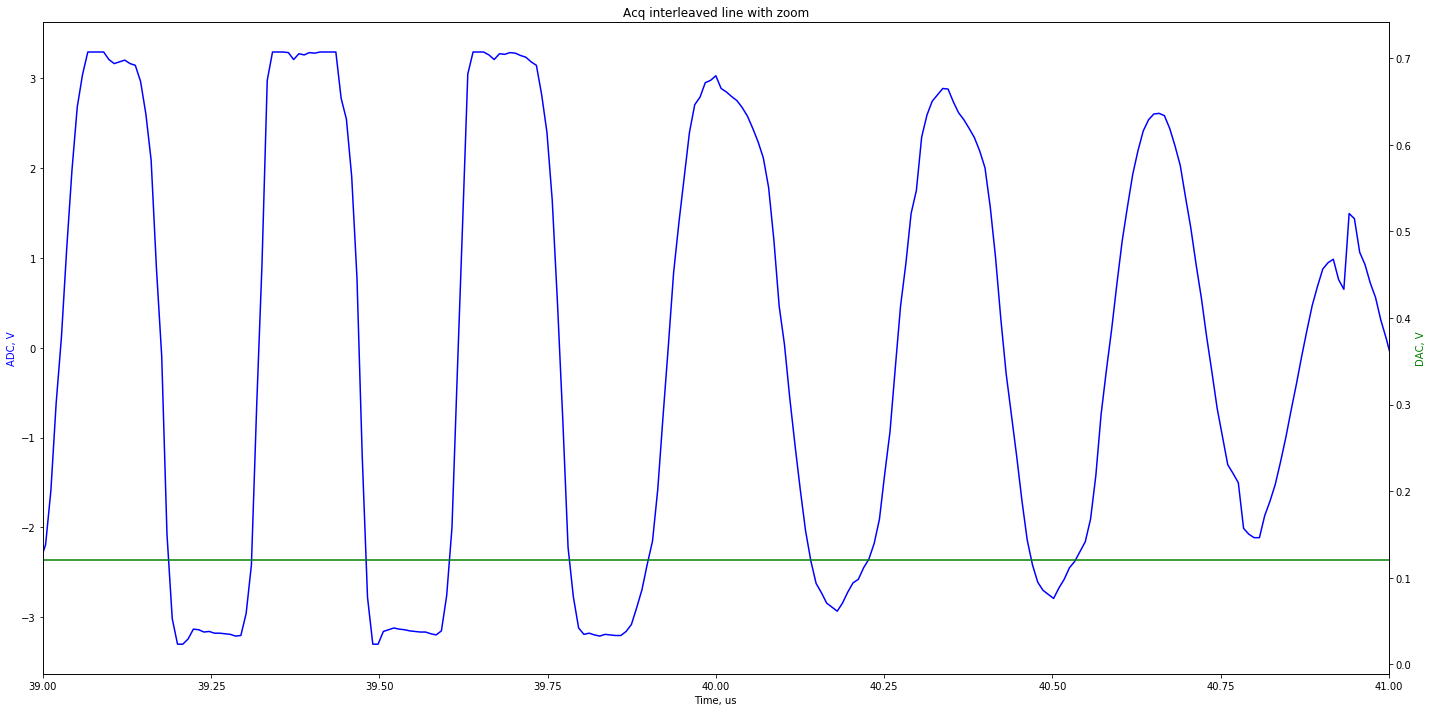

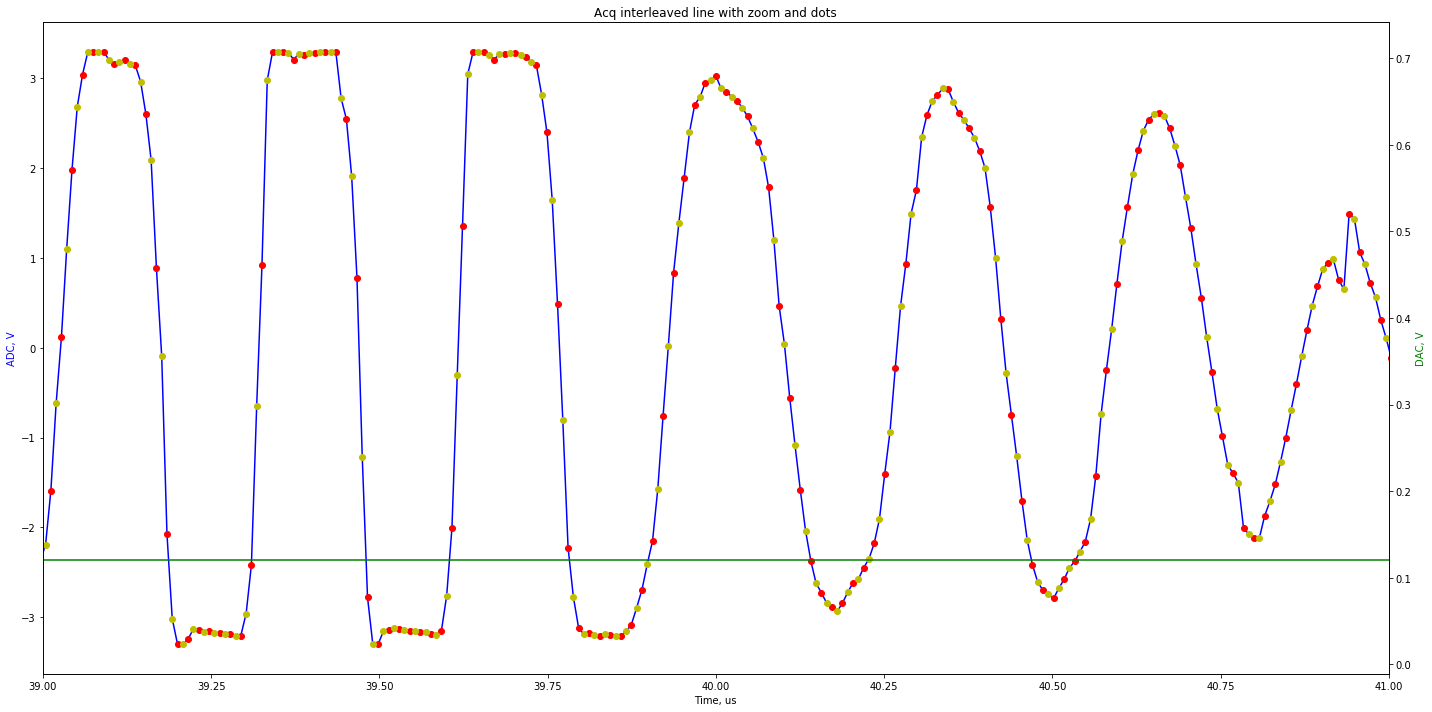

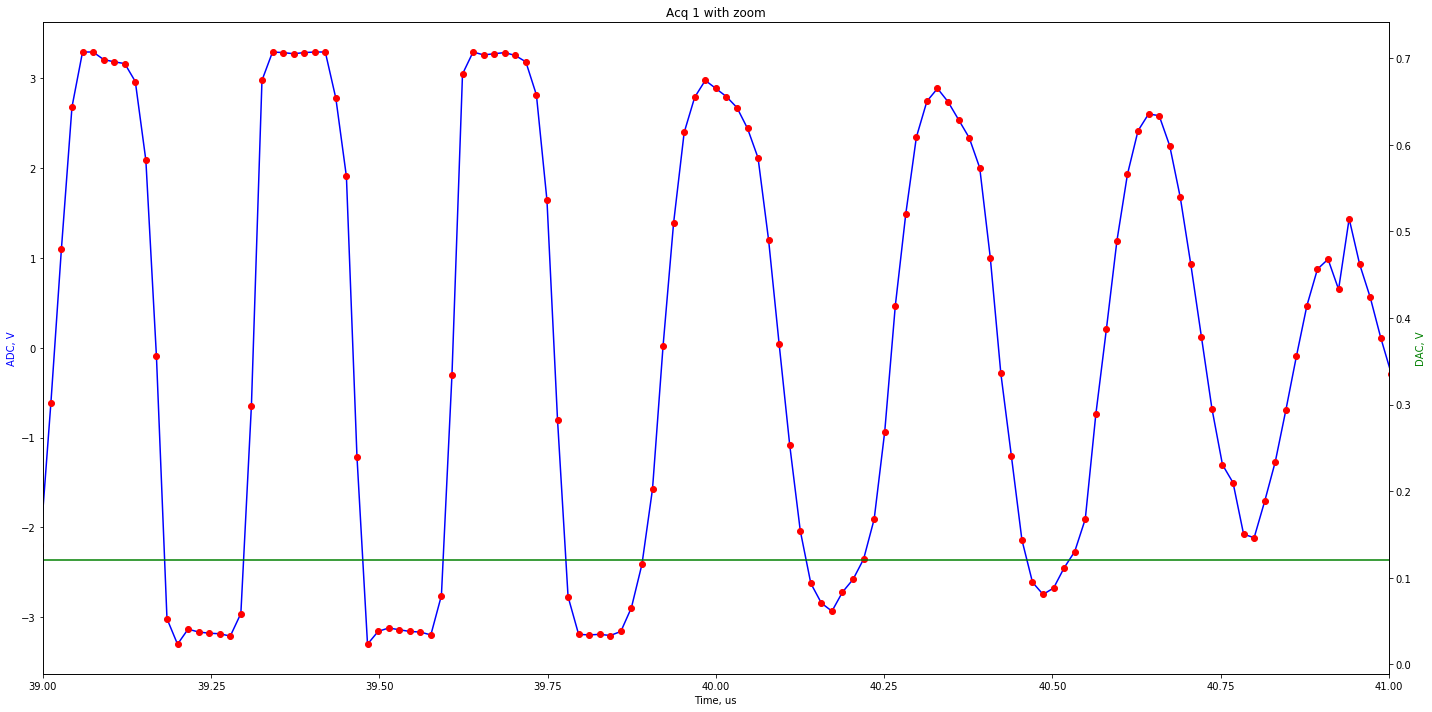

In [8]:
gain = gain_staircase(4, 800)
acq_res = fpga.do_acquisition(acq_lines=2, gain=gain, double_rate=True)

plot_interleaved_lines("Acq interleaved", acq_res[0], acq_res[1], gain)
plot_interleaved_lines("Acq interleaved line with zoom", acq_res[0], acq_res[1], gain, [39.0, 41.0])
plot_interleaved_lines("Acq interleaved line with zoom and dots", acq_res[0], acq_res[1], gain, [39.0, 41.0], True)
plot_line("Acq 1 with zoom", acq_res[1], gain, [39.0, 41.0], True)

### Maximum number of lines

All lines are unique: True


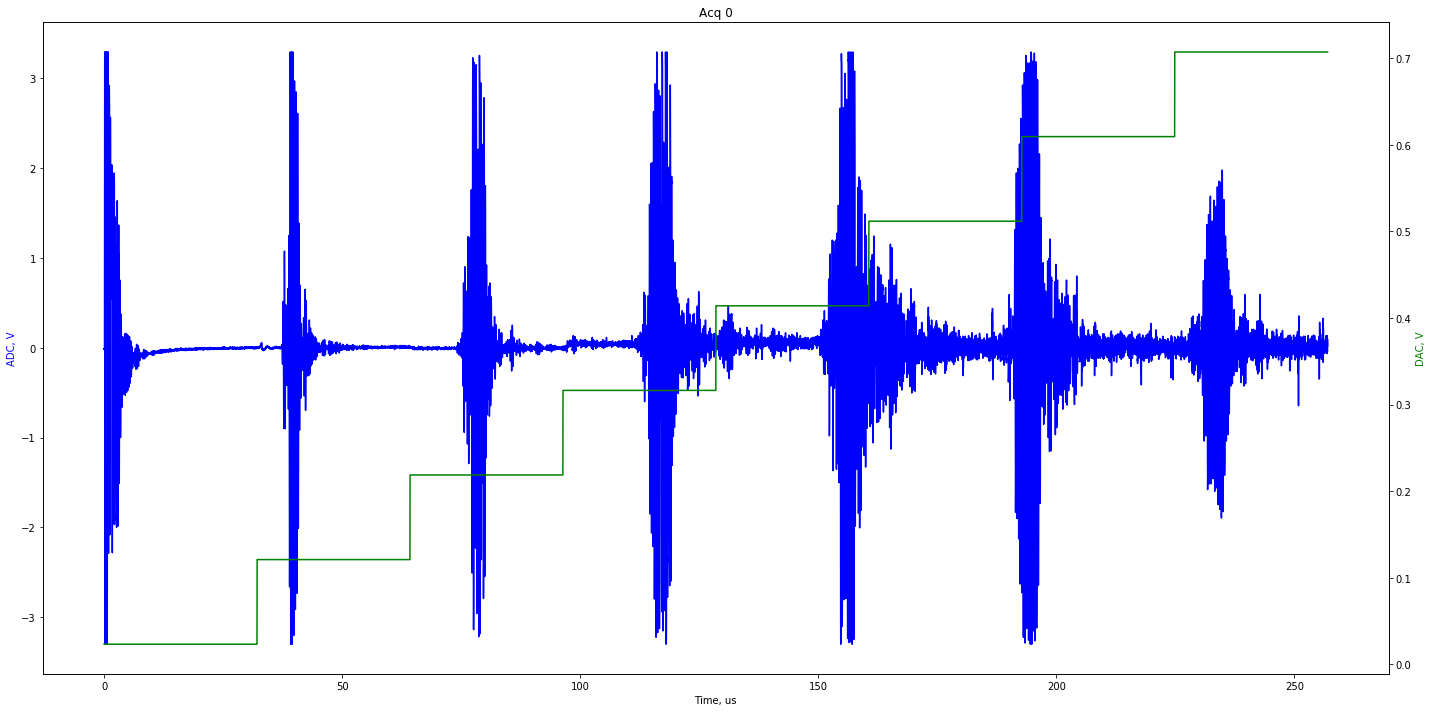

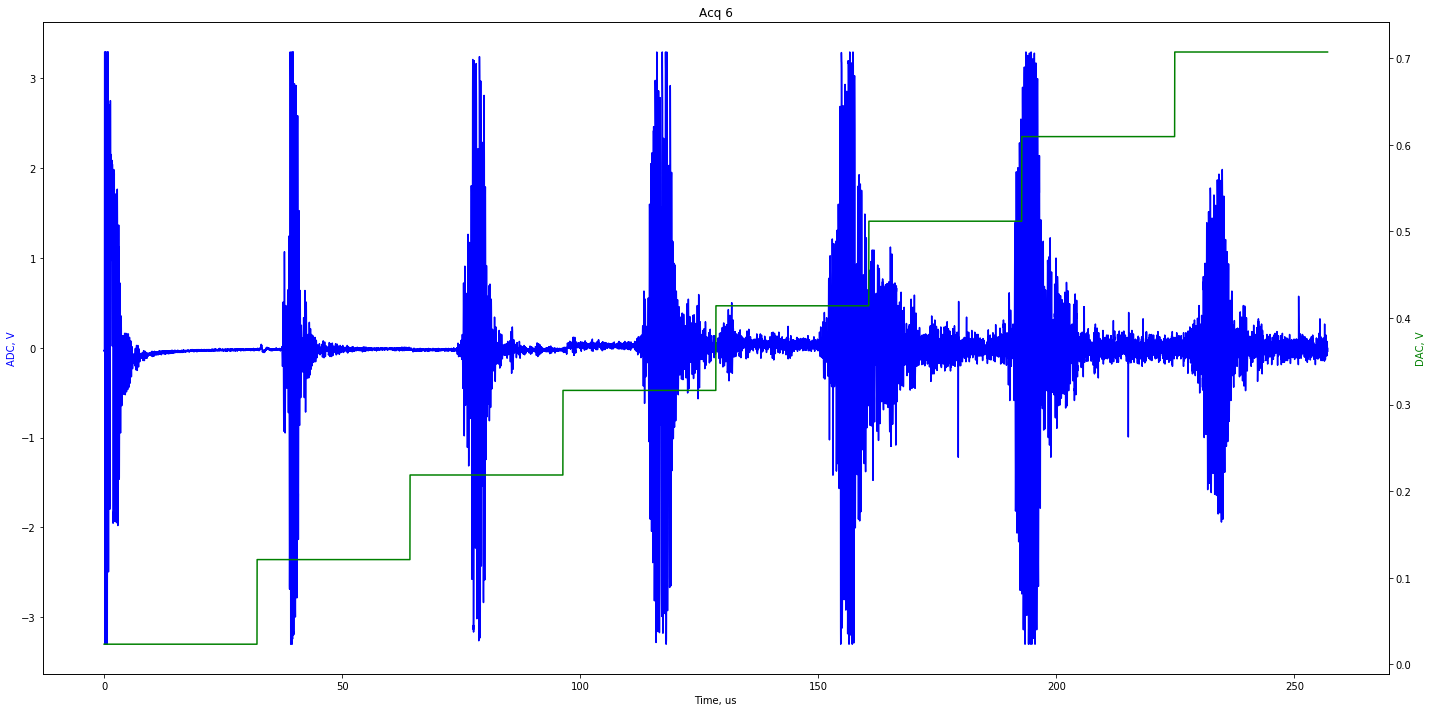

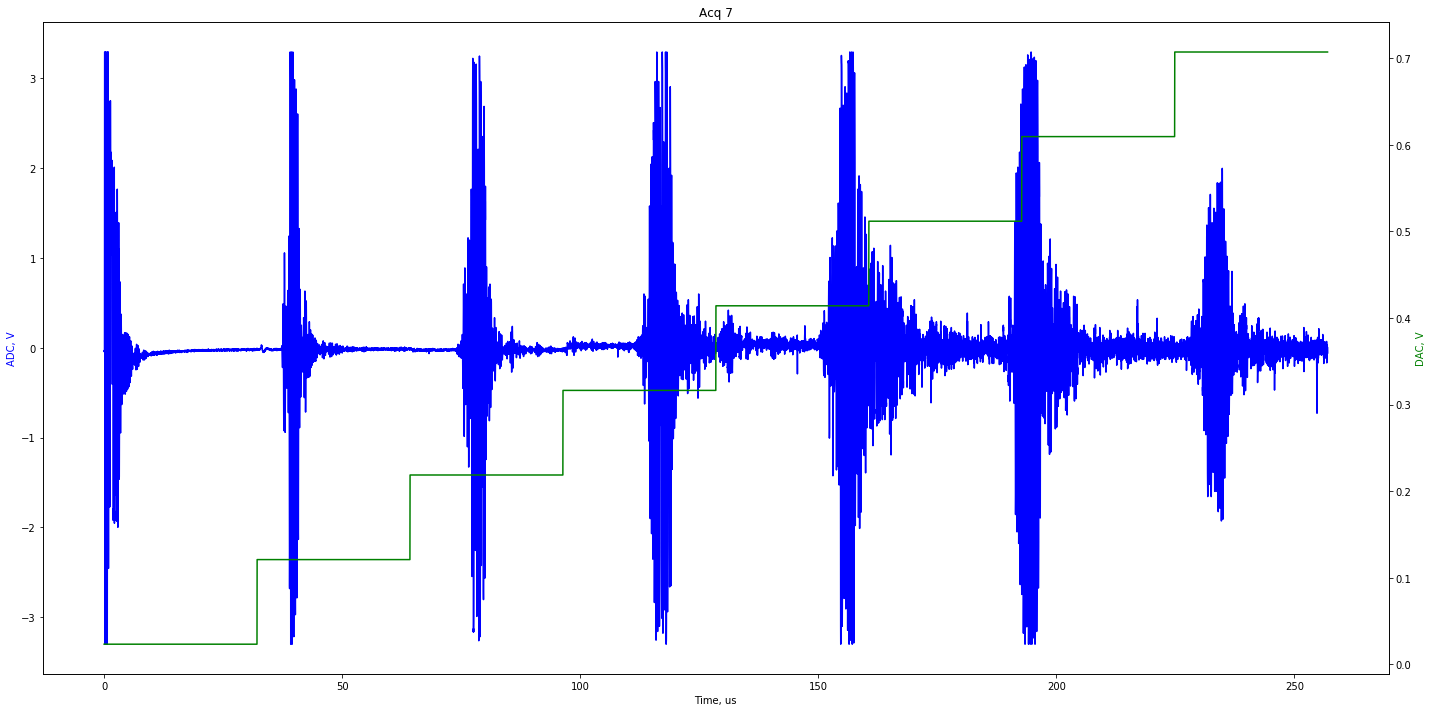

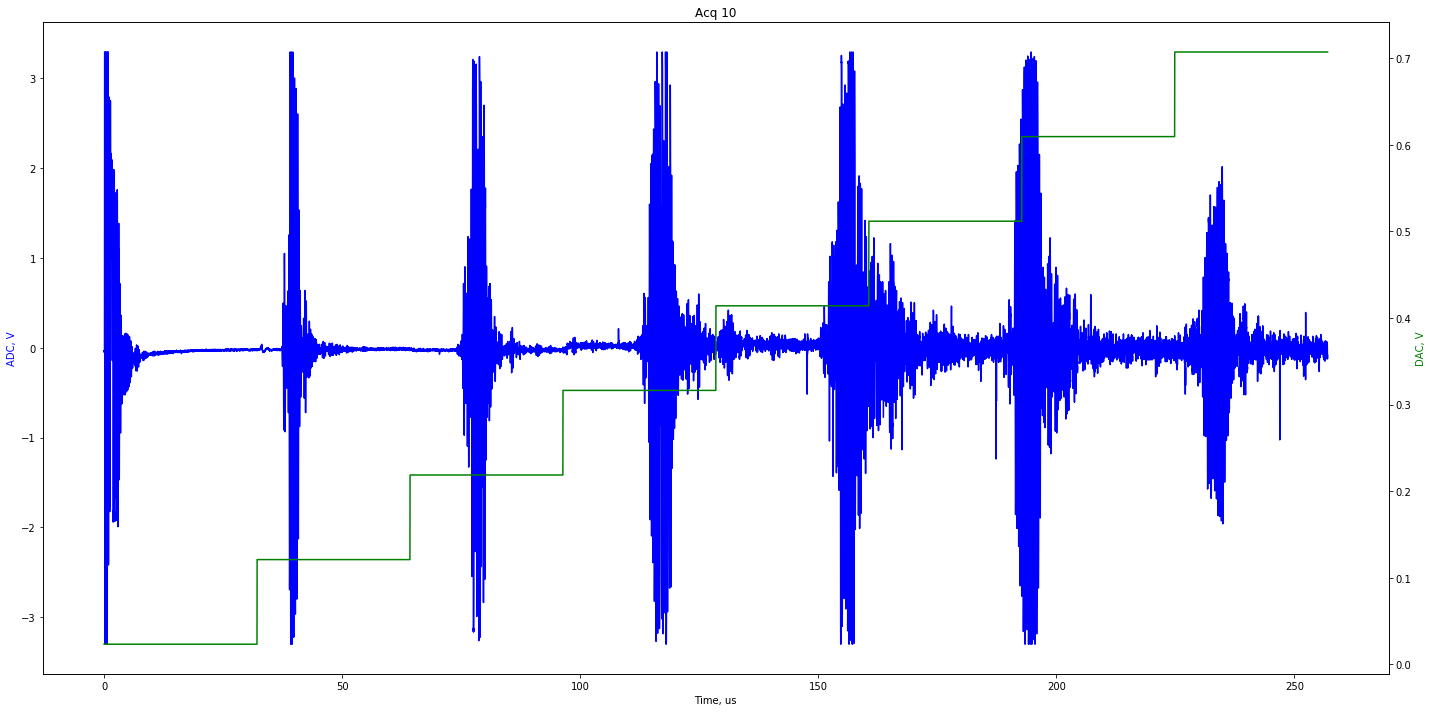

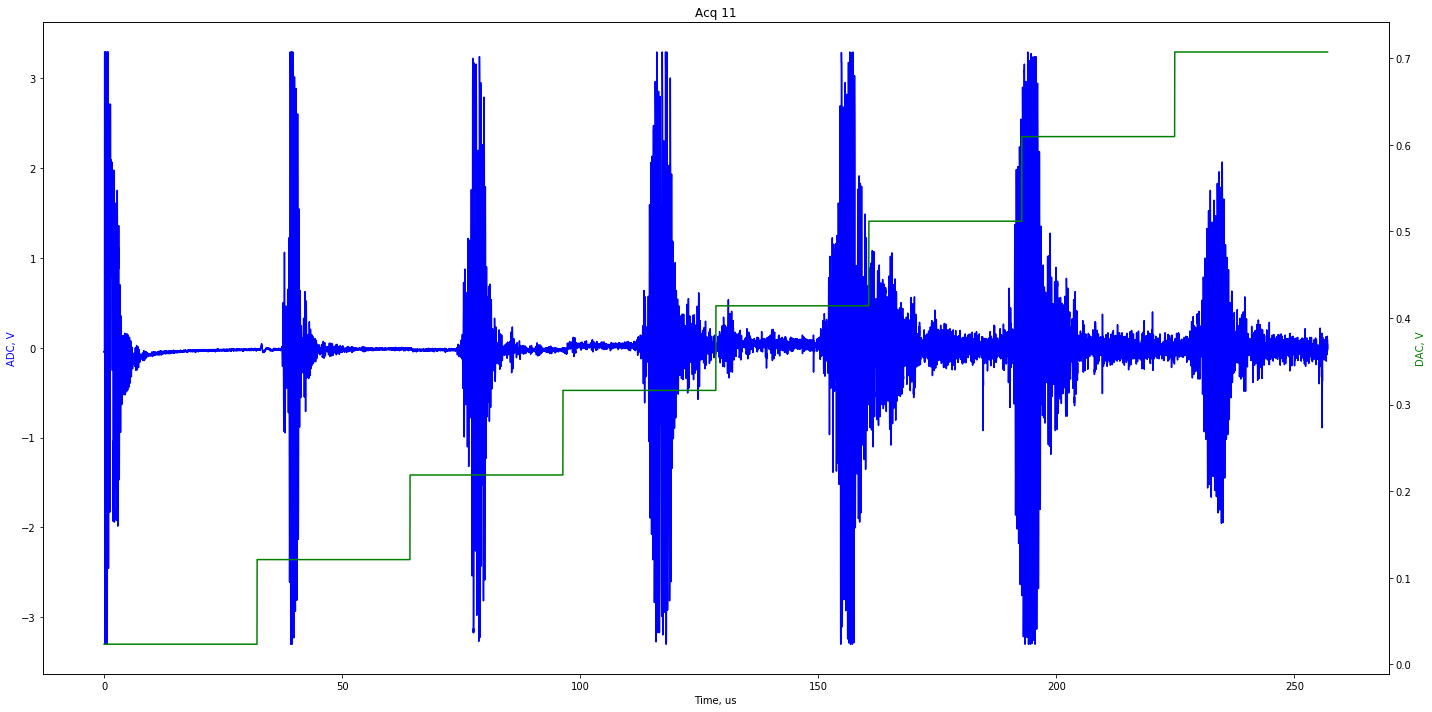

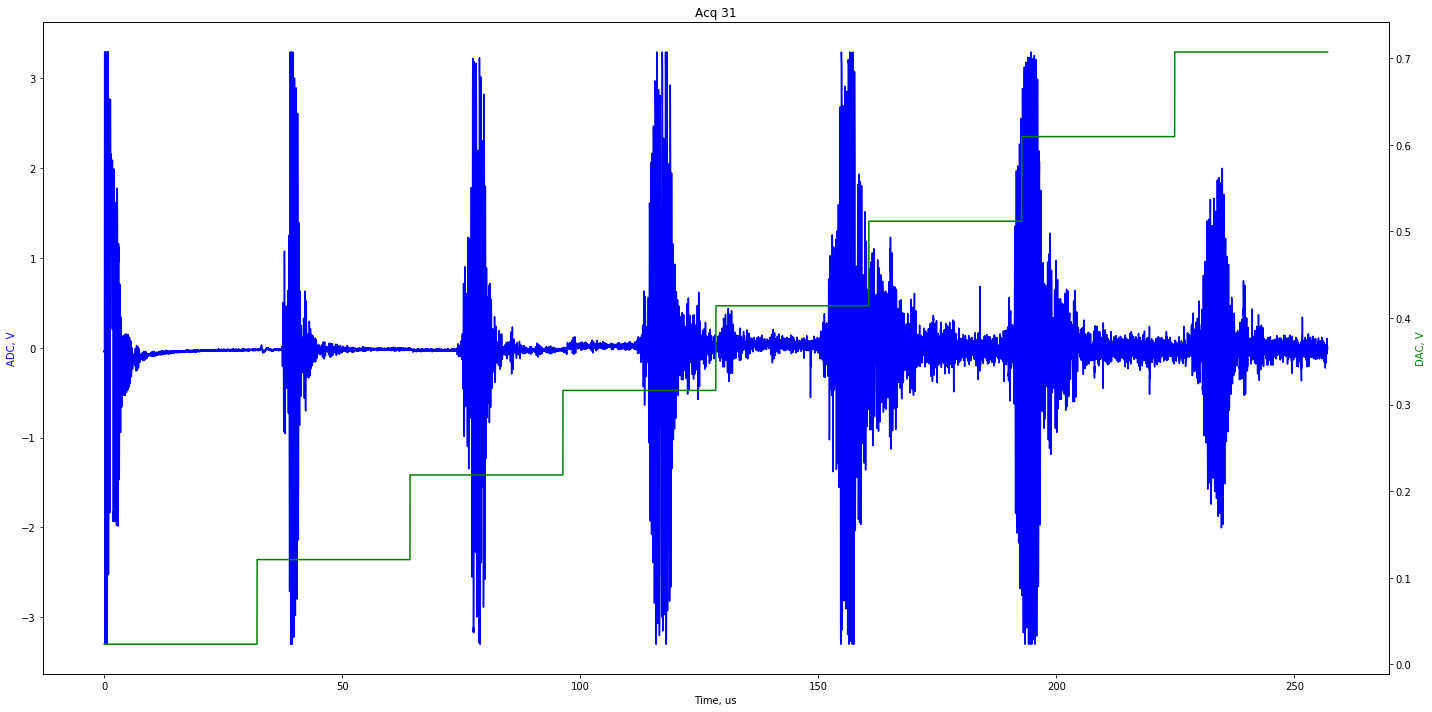

In [9]:
gain = gain_staircase(4, 800)
acq_res = fpga.do_acquisition(acq_lines=32, gain=gain, double_rate=False)

acq_res_hashes = [hash(tuple(a)) for a in acq_res]
print("All lines are unique:", len(acq_res_hashes) == len(set(acq_res_hashes)))

# print first, last and some random lines
plot_line("Acq 0", acq_res[0], gain)
for _ in range(4):
    acq_num = randint(1, 30)
    plot_line("Acq %d" % acq_num, acq_res[acq_num], gain)
plot_line("Acq 31", acq_res[31], gain)


## Disconnect FPGA

In [10]:
# reset fpga again (optional)
fpga.reset()
# close FTDI interface
fpga.disconnect()